In [1]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import pathlib
import yaml
import time

from benchmark_analytical import Parameters, Domain, Testcase, calc_and_plot
import analytical_model_lahm as lahm
from utils_and_visu import _aligned_colorbar

%load_ext autoreload
%autoreload 2

In [2]:
sim_path = pathlib.Path("/home/pelzerja/pelzerja/test_nn/datasets_prepared/1HP_NN/BENCHMARK_BOXES_gksi")
sims = {}
for file in os.listdir(sim_path / "Inputs"):
    sim_in = torch.load(sim_path / "Inputs" / file)
    sim_label = torch.load(sim_path / "Labels" / file)
    sims[file] = (sim_in[0].max(), sim_in[1].max(), sim_label[0])

norm_info = yaml.load(open(sim_path / "info.yaml", "r"), Loader=yaml.FullLoader)

In [3]:
for name, datapoint in sims.items():
    grad_p, k_perm, label = datapoint
    
    # reverse norm of inputs and label
    out_min, out_max = 0, 1
    delta = norm_info["Inputs"]["Pressure Gradient [-]"]["max"] - norm_info["Inputs"]["Pressure Gradient [-]"]["min"]
    grad_p = (grad_p - out_min) / (out_max - out_min) * delta + norm_info["Inputs"]["Pressure Gradient [-]"]["min"]
    delta = norm_info["Inputs"]["Permeability X [m^2]"]["max"] - norm_info["Inputs"]["Permeability X [m^2]"]["min"]
    k_perm = (k_perm - out_min) / (out_max - out_min) * delta + norm_info["Inputs"]["Permeability X [m^2]"]["min"]
    delta = norm_info["Labels"]["Temperature [C]"]["max"] - norm_info["Labels"]["Temperature [C]"]["min"]
    label = (label - out_min) / (out_max - out_min) * delta + norm_info["Labels"]["Temperature [C]"]["min"]

    sims[name] = (grad_p.numpy(), k_perm.numpy(), np.array(label).T)

In [4]:
def calc_k_cond(k_perm, eta, rho_w, g):
    return k_perm/(eta/(rho_w*g))

In [5]:
def plot_temperature_field(data, x_grid, y_grid, filename="", params=None):
    """
    Plot the temperature field.
    """
    n_subplots = 3
    _, axes = plt.subplots(n_subplots,1,sharex=True,figsize=(38.4,3*(n_subplots)))
    
    max_temp = 16 #data[list(data.keys())[0]].max()
    min_temp = 10 #data[list(data.keys())[0]].min()
    lengths = {}
    widths = {}
    for index, (key, value) in enumerate(data.items()):
        plt.sca(axes[index])
        plt.title(f"{key}")
        if params:
            # levels = [params.T_gwf, params.T_gwf + 1, params.T_gwf + params.T_inj_diff]
            left_bound, right_bound = 1280, 0
            upper_bound, lower_bound = 0, 80
            if value.max() > params.T_gwf + 1:
                levels = [params.T_gwf + 1] 
                CS = plt.contour(x_grid, y_grid, value, levels=levels, cmap='Pastel1', extent=(0,1280,100,0))
                plt.clabel(CS, inline=1, fontsize=10)

                # calc maximum width and length of 1K-isoline
                for level in CS.allsegs:
                    for seg in level:
                        # print(seg[:,0].max(), seg[:,0].min(), seg[:,1].max(), seg[:,1].min())
                        right_bound = max(right_bound, seg[:,0].max())
                        left_bound = min(left_bound, seg[:,0].min())
                        upper_bound = max(upper_bound, seg[:,1].max())
                        lower_bound = min(lower_bound, seg[:,1].min())
            lengths[key] = max(right_bound - left_bound, 0)
            widths[key] = max(upper_bound - lower_bound, 0)
            print(f"{key} length (max y): {lengths[key]}, width (max x): {widths[key]}, max temp: {value.max()}")

            if key == "Diff":
                plt.imshow(value, cmap="RdBu_r", extent=(0,1280,80,0))
            else:
                plt.imshow(value, cmap="RdBu_r", extent=(0,1280,80,0), vmin=min_temp, vmax=max_temp)
            plt.gca().invert_yaxis()
        # else:
        #     levels = np.arange(10.6, 15.6, 0.25)
        #     plt.contourf(x_grid, y_grid, value, levels=levels, cmap='RdBu_r', extent=(0,1280,100,0))
        plt.ylabel("x [m]")
        _aligned_colorbar(label="Temperature [°C]")

    plt.xlabel("y [m]")
    plt.show()
    # plt.savefig(f"{filename}.png")
    # plt.savefig(f"{filename}.svg")

    return lengths, widths

RUN_1.pt 50.8804659648 0.000588894282 10.746912739201719 10.992068
LAHM length (max y): 0, width (max x): 0, max temp: 10.746912739201719
label length (max y): 0, width (max x): 0, max temp: 10.99206829071045
Diff length (max y): 0, width (max x): 0, max temp: 0.3828743732333031


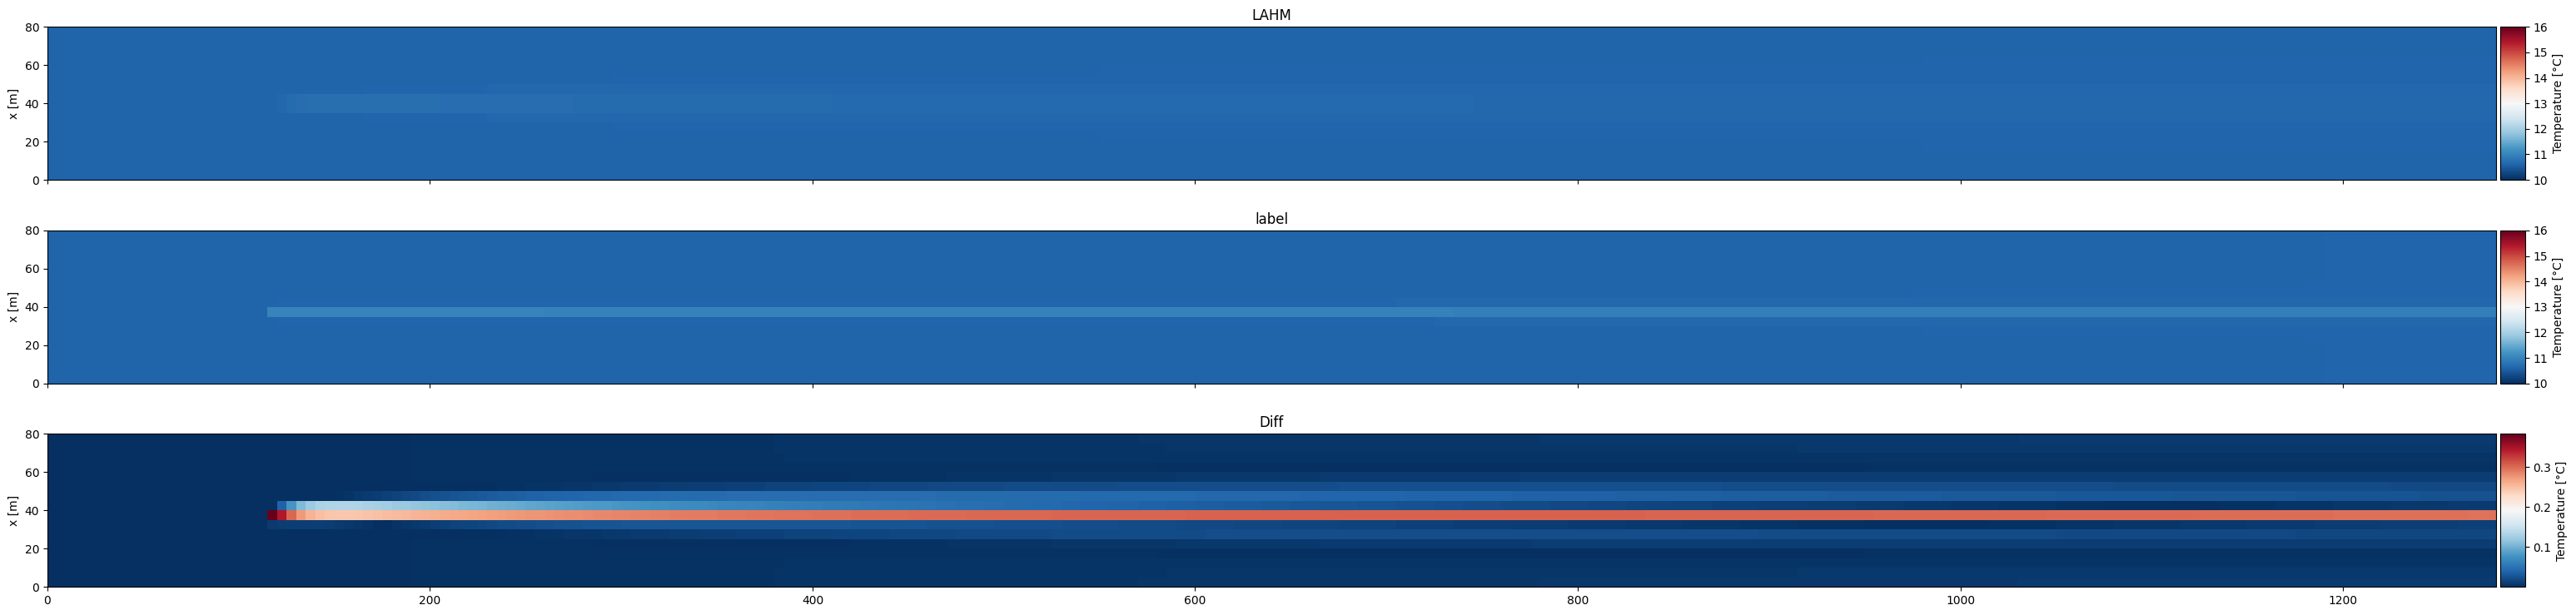

benchmark loss (MSE): 0.005276836108619859, length: 0%, width: 0%, max-temp: 2.23%


RUN_2.pt 0.3158097984 3.655206e-06 34.269273925696666 15.599893
LAHM length (max y): 1166.253130318143, width (max x): 57.76518241350233, max temp: 34.269273925696666
label length (max y): 610.5808979828946, width (max x): 80.0, max temp: 15.599892616271973
Diff length (max y): 149.85118949826668, width (max x): 10.61717444059336, max temp: 18.6902324446786


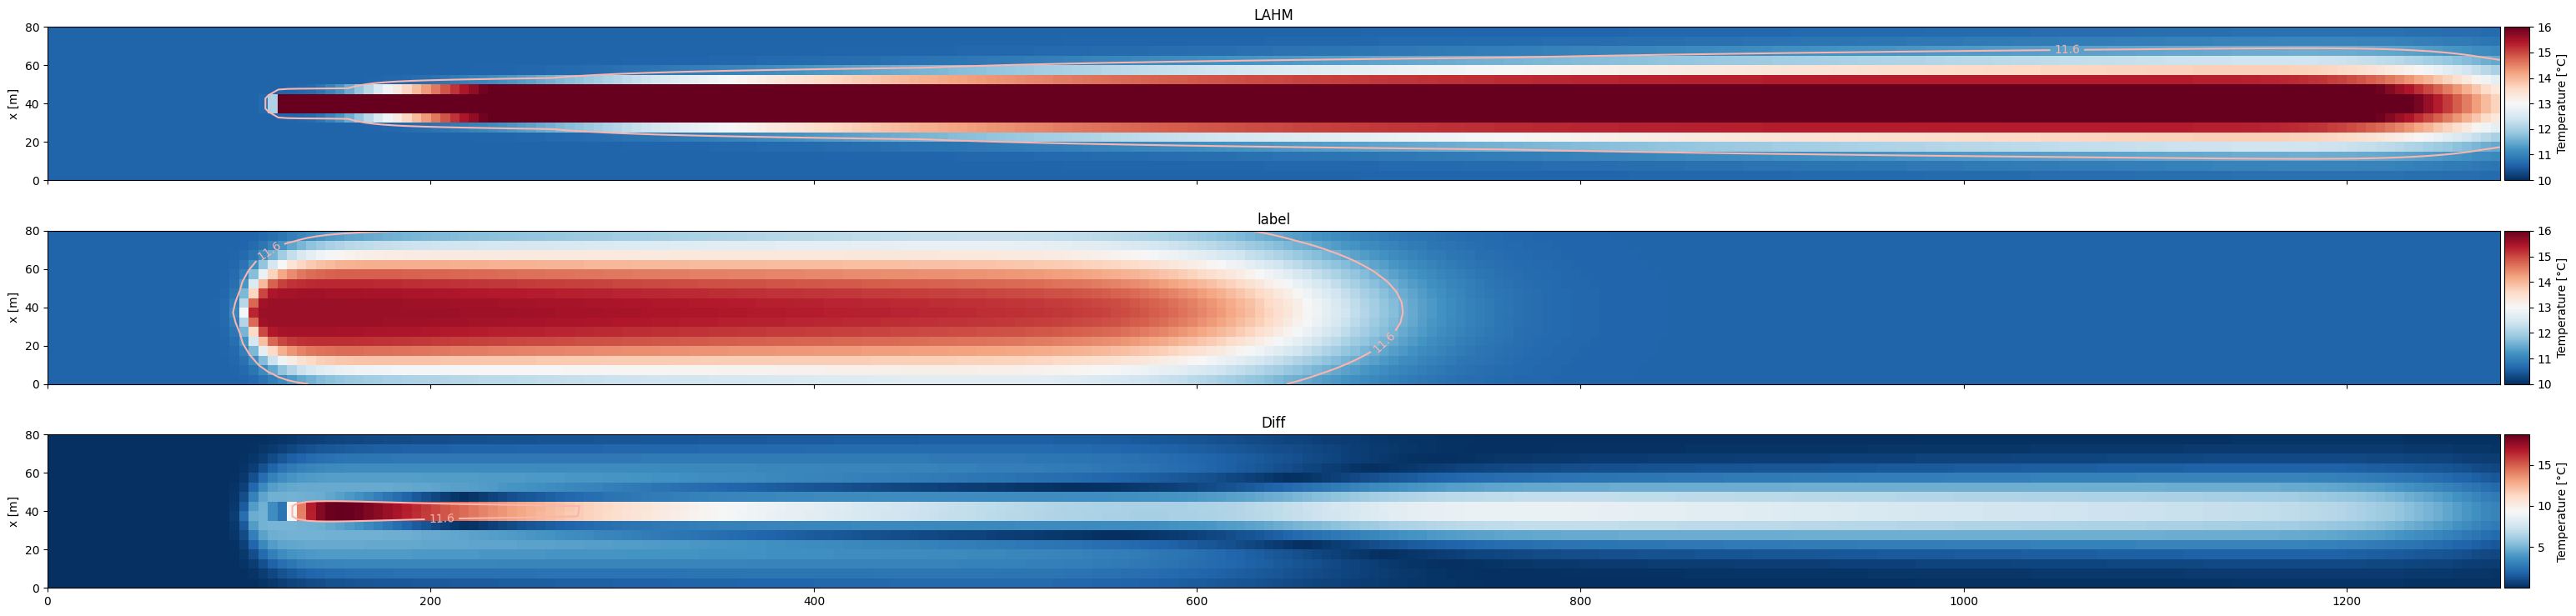

benchmark loss (MSE): 16.512194481559245, length: 91.01%, width: 27.79%, max-temp: 119.68%


RUN_3.pt 0.9357328224 1.0830241e-05 18.58837921232316 15.562272
LAHM length (max y): 1163.308926164884, width (max x): 39.76761040647178, max temp: 18.58837921232316
label length (max y): 1169.4338957740636, width (max x): 51.20290227387325, max temp: 15.562272071838379
Diff length (max y): 0, width (max x): 0, max temp: 4.4623528704585365


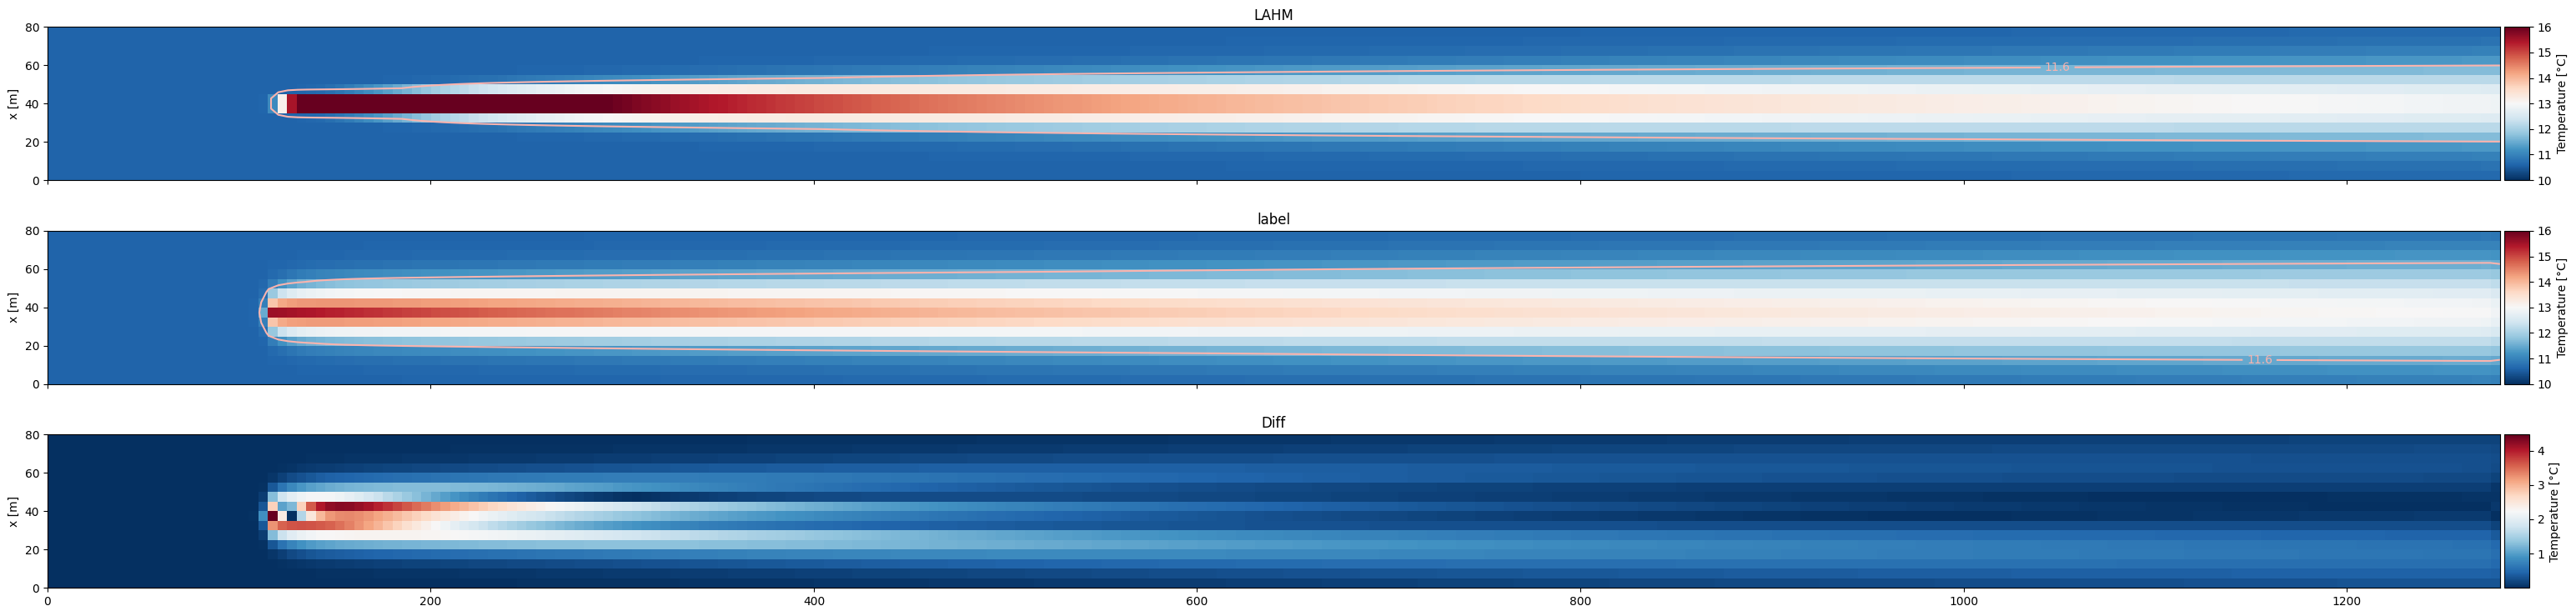

benchmark loss (MSE): 0.4584336119145198, length: 0.52%, width: 22.33%, max-temp: 19.45%


RUN_4.pt 22.26942288 0.00025774795 10.93566153317165 11.429625
LAHM length (max y): 0, width (max x): 0, max temp: 10.93566153317165
label length (max y): 0, width (max x): 0, max temp: 11.429624557495117
Diff length (max y): 0, width (max x): 0, max temp: 0.8086185885573585


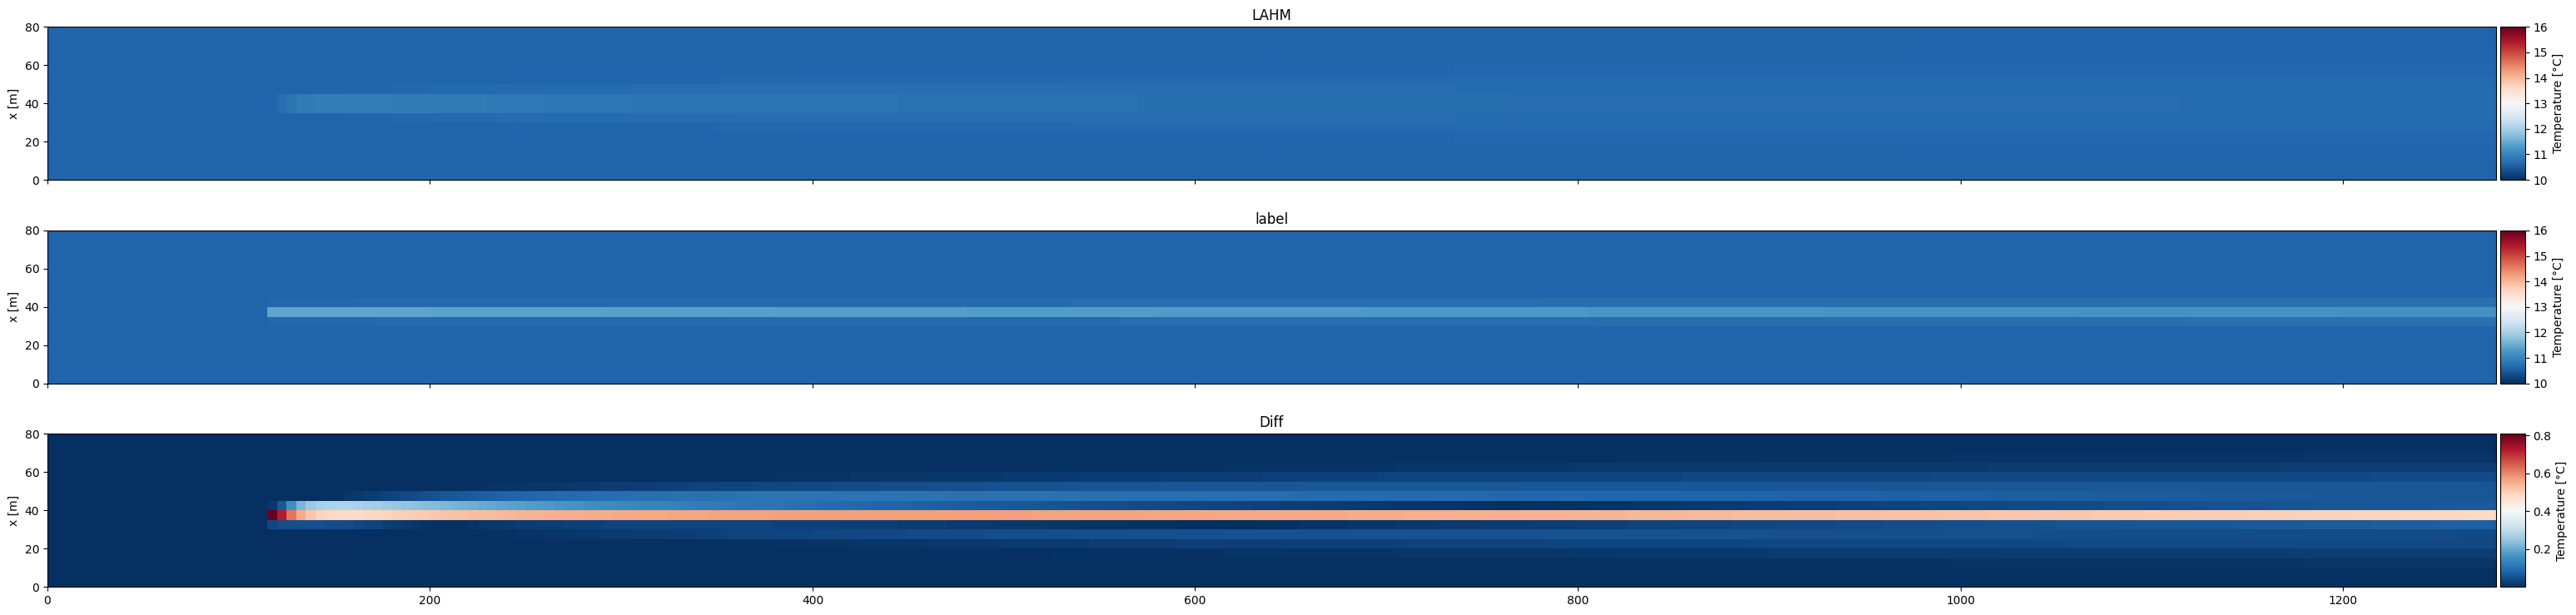

benchmark loss (MSE): 0.01800268781178401, length: 0%, width: 0%, max-temp: 4.32%


RUN_5.pt 0.138224016 1.599815e-06 64.6787979040389 15.600359
LAHM length (max y): 564.5900257726391, width (max x): 47.99192811217563, max temp: 64.6787979040389
label length (max y): 414.16909726967936, width (max x): 80.0, max temp: 15.600358963012695
Diff length (max y): 501.74953694451233, width (max x): 23.548244344612023, max temp: 49.07848662474203


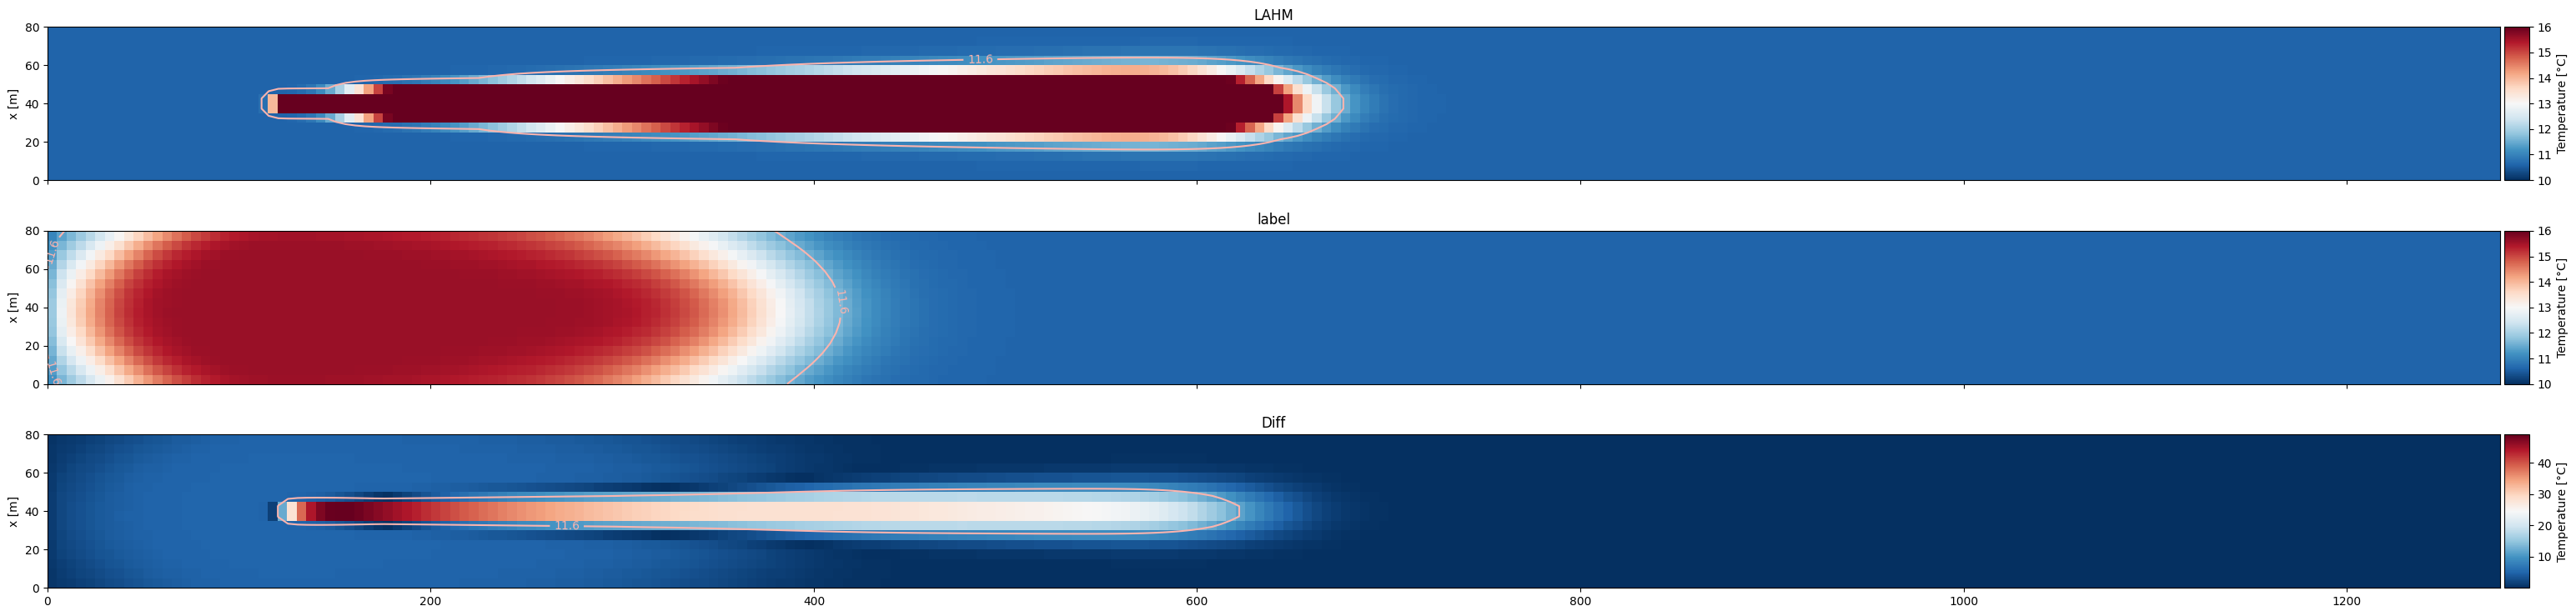

benchmark loss (MSE): 64.26676810783681, length: 36.32%, width: 40.01%, max-temp: 314.6%


RUN_6.pt 0.4095526752 4.740193e-06 28.851592723935504 15.5986395
LAHM length (max y): 1165.2020237118006, width (max x): 56.17939279618838, max temp: 28.851592723935504
label length (max y): 757.8240923948172, width (max x): 80.0, max temp: 15.598639488220215
Diff length (max y): 54.83610034933233, width (max x): 7.35882830637258, max temp: 13.358448688596148


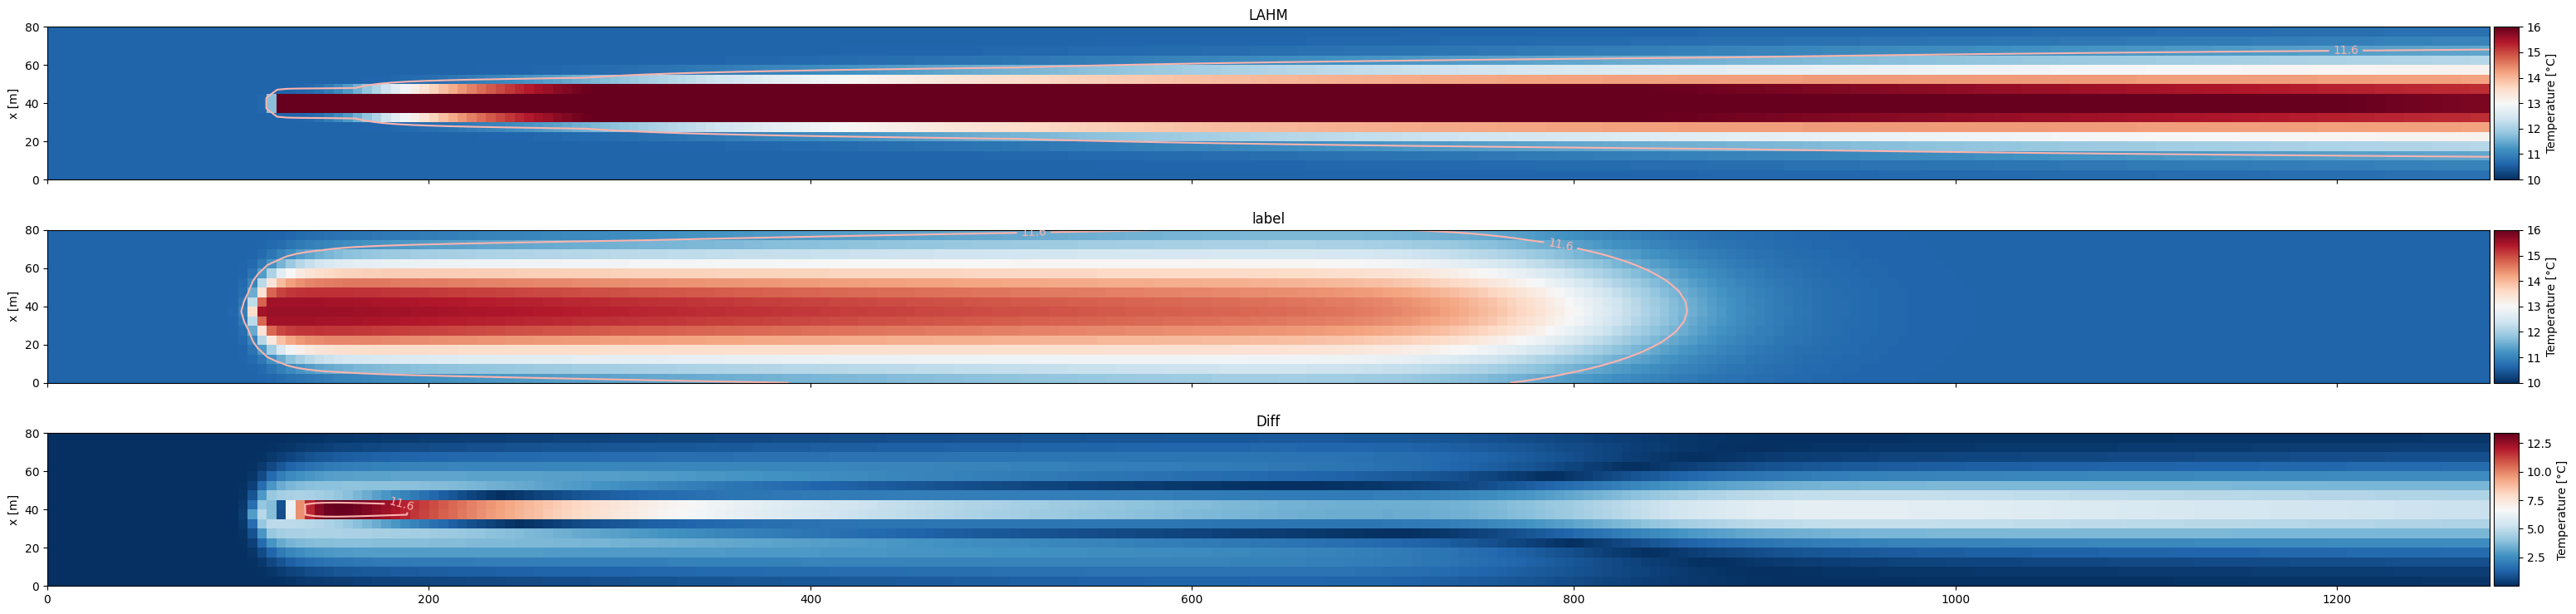

benchmark loss (MSE): 8.186676204744742, length: 53.76%, width: 29.78%, max-temp: 84.96%


RUN_7.pt 29.495924064 0.00034138801 10.8534244599535 11.246921
LAHM length (max y): 0, width (max x): 0, max temp: 10.8534244599535
label length (max y): 0, width (max x): 0, max temp: 11.246920585632324
Diff length (max y): 0, width (max x): 0, max temp: 0.6310610789335644


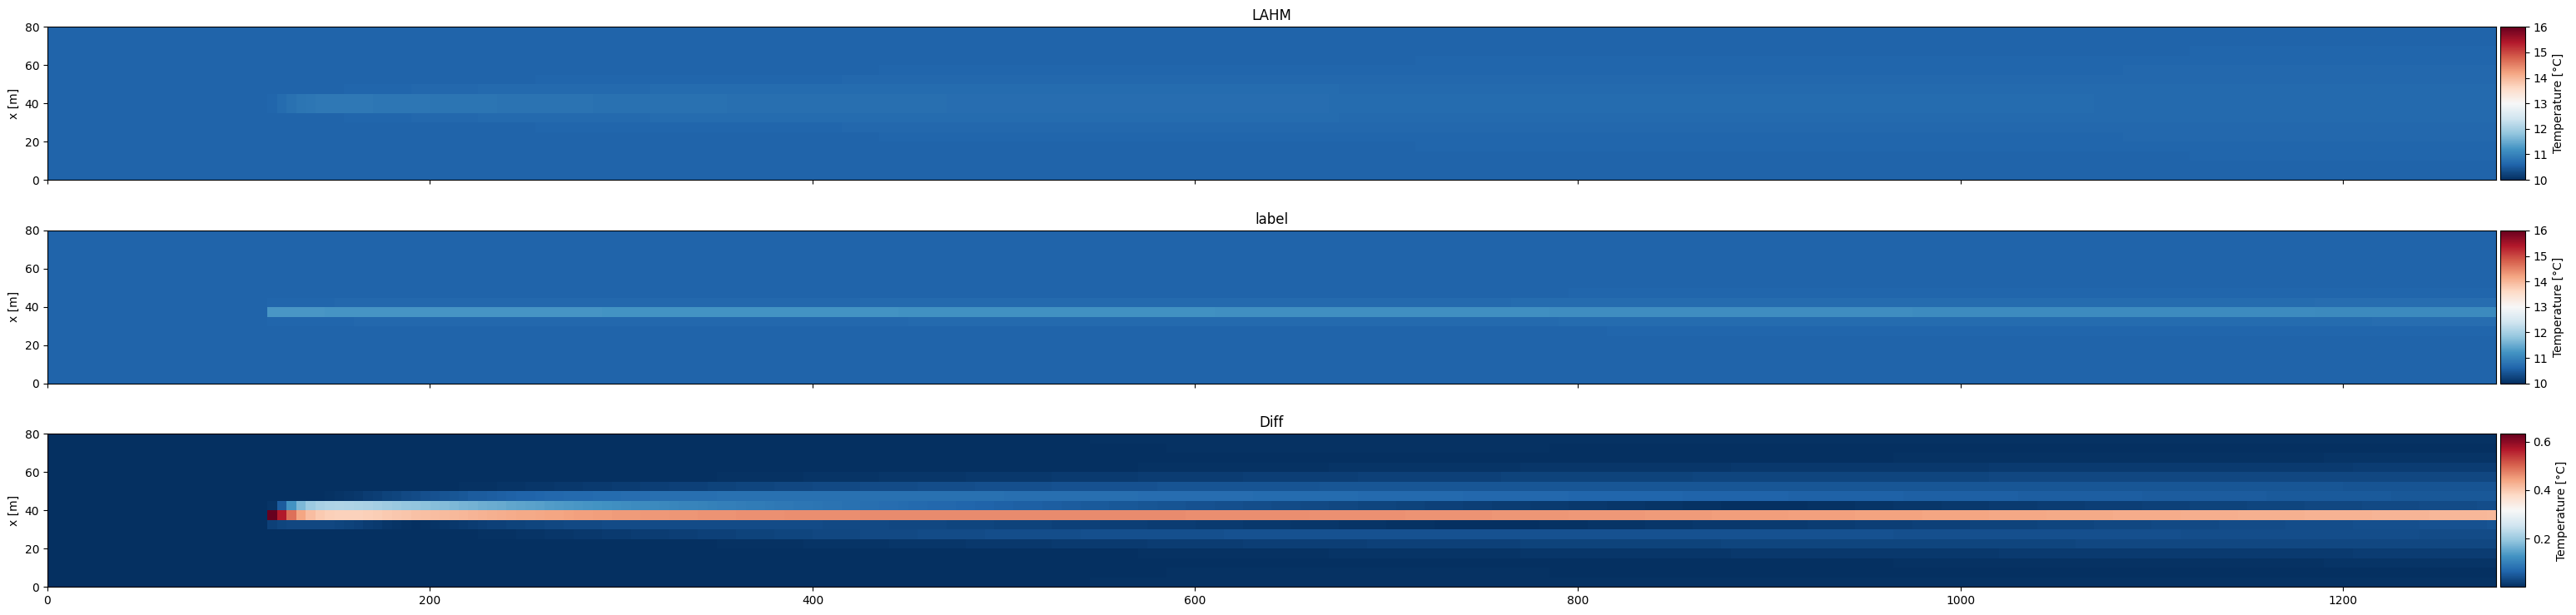

benchmark loss (MSE): 0.012186295547360301, length: 0%, width: 0%, max-temp: 3.5%


RUN_8.pt 0.183078144 2.11896e-06 51.429497521826754 15.600377
LAHM length (max y): 729.5384040042003, width (max x): 52.89066981124062, max temp: 51.429497521826754
label length (max y): 440.6239549397085, width (max x): 80.0, max temp: 15.600377082824707
Diff length (max y): 640.268638684077, width (max x): 18.924007029299943, max temp: 35.8291700300665


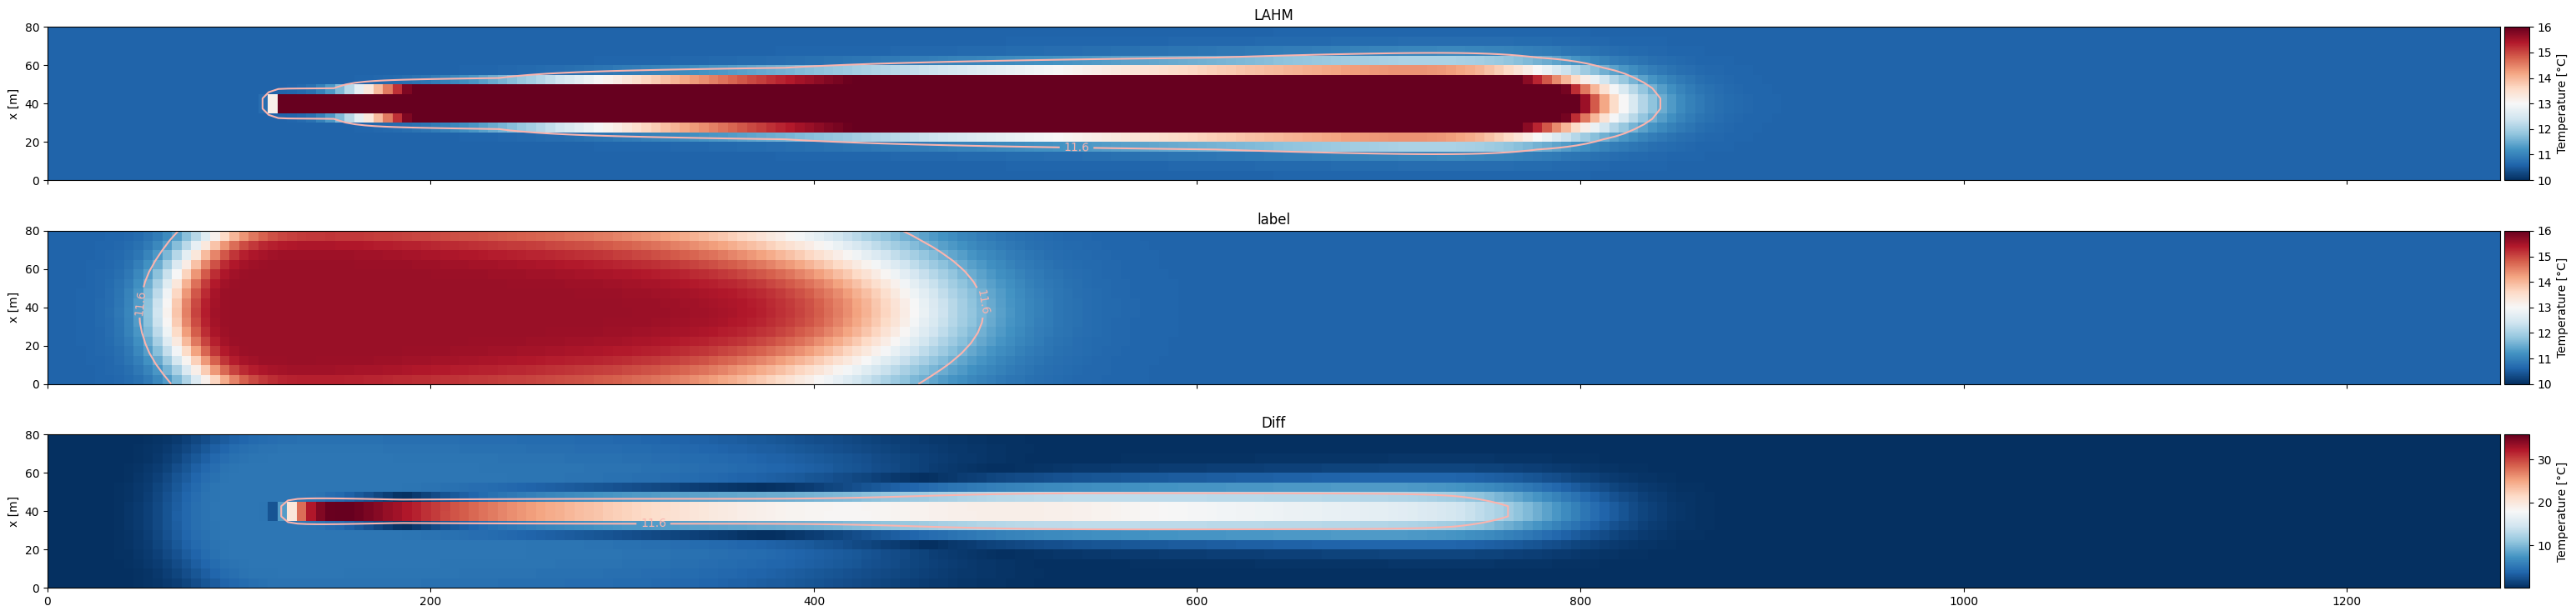

benchmark loss (MSE): 41.88967810461034, length: 65.57%, width: 33.89%, max-temp: 229.67%


RUN_9.pt 0.5424538464 6.278401e-06 24.37995321879727 15.592889
LAHM length (max y): 1164.3511550341614, width (max x): 51.24745849655267, max temp: 24.37995321879727
label length (max y): 965.3775325503069, width (max x): 72.53227965013413, max temp: 15.592888832092285
Diff length (max y): 0, width (max x): 0, max temp: 9.139338327745023


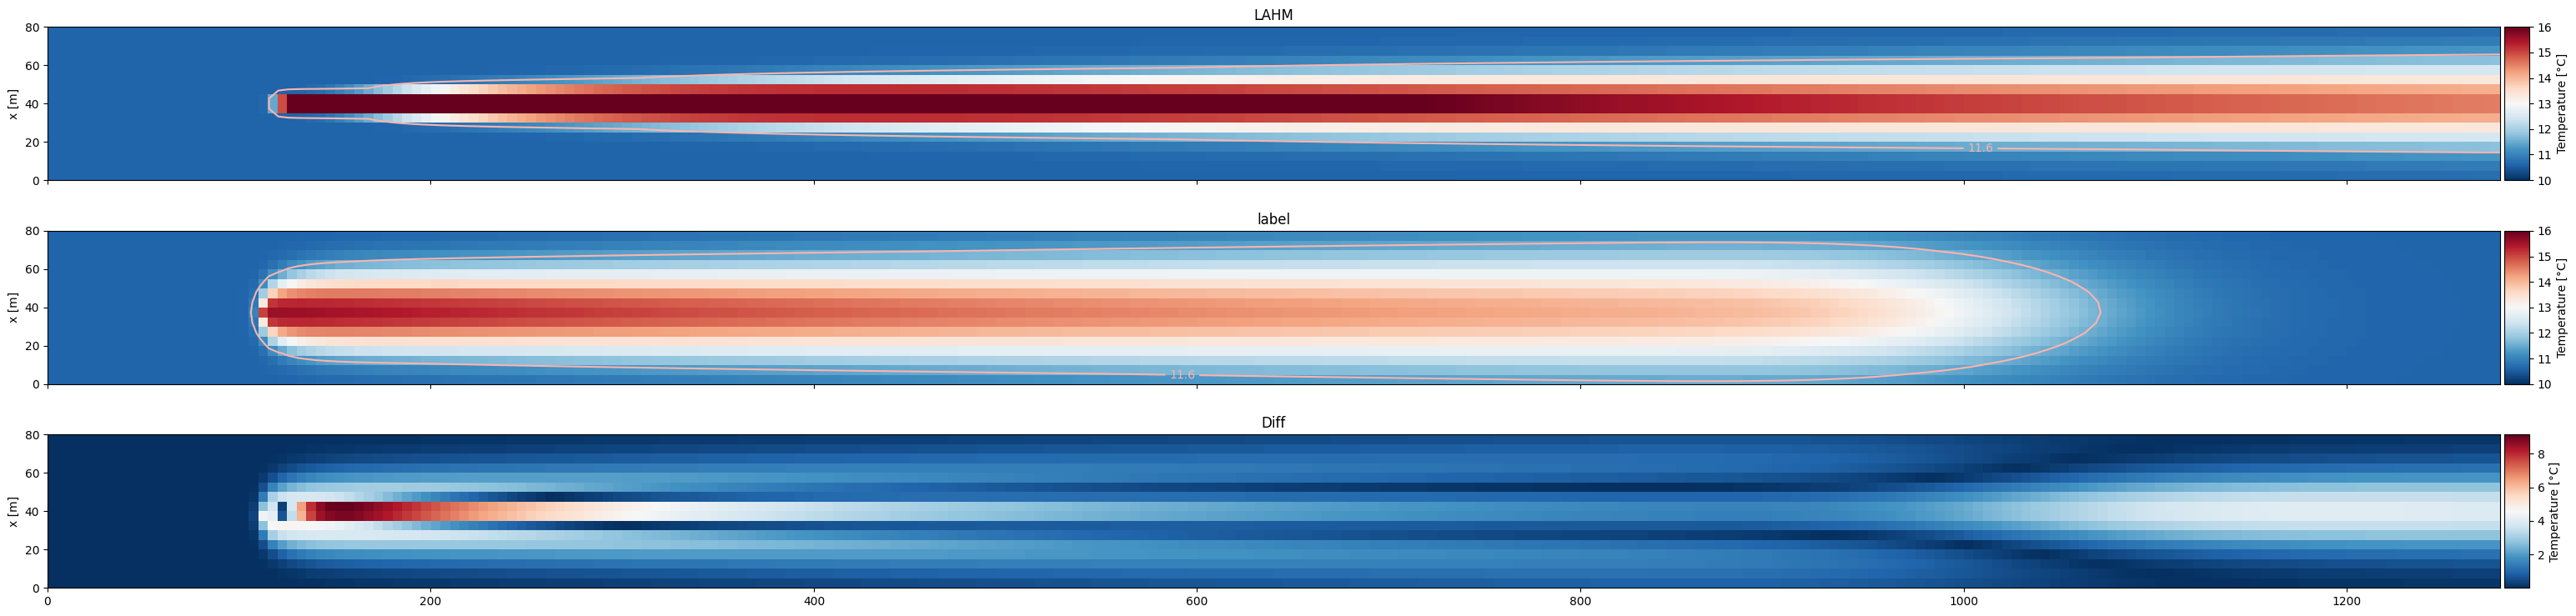

benchmark loss (MSE): 3.199802603187651, length: 20.61%, width: 29.35%, max-temp: 56.35%


overall MSE: 14.949890992591232
overall length: 44.63%, overall width: 30.52%, overall max-temp: 92.75%
overall length 2: 29.75%, overall width 2: 20.35%
duration init: 0.0006965789943933487, duration run: 0.0004023592272359464, duration total: 4.055089419998694


In [10]:
# calc LAHM for all testcases
time_begin = time.perf_counter()
params = Parameters(time_sim = np.array([27.5 - 72/365]), time_sim_sec=np.array([27.5 - 72/365]) * 365 * 24 * 60 * 60)
domain = Domain()
domain.cell_size=5
domain.x_lin = np.linspace(0, 1280, 256)
domain.y_lin=np.linspace(0, 80, 16)
domain.x_grid, domain.y_grid = np.meshgrid(domain.x_lin, domain.y_lin)
domain.injection_point = (23*domain.cell_size, 8*domain.cell_size)

overall_mse = 0
overall_length = 0
num_length = 0
overall_width = 0
num_width = 0
overall_max_temp = 0
approach = "lahm"
sim_time  = params.time_sim_sec[0]
duration_run = 0
duration_init = time.perf_counter() - time_begin

for name, datapoint in sims.items():
    start_run = time.perf_counter()
    data = {}
    grad_p, k_perm, label = datapoint
    k_cond = calc_k_cond(k_perm, params.eta, params.rho_w, params.g)
    testcase = Testcase(name, grad_p, k_cond=k_cond, k_perm=k_perm)
    testcase.post_init(params)
    delta_T_grid = params.T_gwf + lahm.delta_T(domain.x_grid-domain.injection_point[0], domain.y_grid-domain.injection_point[1], sim_time, params, testcase)
    duration_run += time.perf_counter() - start_run
    print(testcase.name, testcase.v_a_m_per_day, testcase.v_a, delta_T_grid.max(), label.max())
    data["LAHM"] = delta_T_grid
    data["label"] = label
    data["Diff"] = abs(delta_T_grid - label)
    lengths, width = plot_temperature_field(data, domain.x_grid, domain.y_grid, filename=f"{testcase.name}_{approach}_combined", params=params)
    
    bm_loss = 1/np.prod(delta_T_grid.shape) * np.sum((delta_T_grid - label)**2)
    overall_mse += bm_loss
    try:
        length = abs(lengths["LAHM"] - lengths["label"])/lengths["label"]
        num_length += 1
    except:
        if lengths["LAHM"] == 0 and lengths["label"] == 0:
            length = 0
        else:
            print(lengths)
    try:
        width = abs(width["LAHM"] - width["label"])/width["label"]
        num_width += 1
    except:
        if width["LAHM"] == 0 and width["label"] == 0:
            width = 0
        else:
            print(width)
    overall_length += length
    overall_width += width
    max_temp = abs(delta_T_grid.max()-label.max())/label.max()
    overall_max_temp += max_temp
    print(f"benchmark loss (MSE): {bm_loss}, length: {round(length*100, 2)}%, width: {round(width*100, 2)}%, max-temp: {round(max_temp*100,2)}%") 
    #TODO check if same for NN
    print("\n")
          
duration_total = time.perf_counter() - time_begin
overall_mse = overall_mse / len(sims)
overall_length_1 = overall_length / num_length
overall_length_2 = overall_length / len(sims)
overall_width_1 = overall_width / num_width
overall_width_2 = overall_width / len(sims)
overall_max_temp = overall_max_temp / len(sims)
duration_run = duration_run / len(sims)
print(f"overall MSE: {overall_mse}")
print(f"overall length: {round(overall_length_1*100, 2)}%, overall width: {round(overall_width_1*100, 2)}%, overall max-temp: {round(overall_max_temp*100,2)}%")
print(f"overall length 2: {round(overall_length_2*100, 2)}%, overall width 2: {round(overall_width_2*100, 2)}%")
print(f"duration init: {duration_init}, duration run: {duration_run}, duration total: {duration_total}")

overall length: 29.75%, overall width: 20.35%, overall max-temp: 92.75%
overall with num_length =/= len(sims): overall length: 44.63%, overall width: 30.52%, overall max-temp: 92.75%